In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import TextDataset
import torch 
from torch import nn

/home/dzhunk/University/lillama/dataset.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
!wget --quiet --show-progress "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories_all_data.tar.gz"
!mkdir tiny_stories
!cd tiny_stories; tar -xvzf ../TinyStories_all_data.tar.gz

TinyStories_all_dat 100%[===================>]   1.50G  26.4MB/s    in 51s     
./
./data22.json
./data34.json
./data18.json
./data04.json
./data07.json
./data30.json
./data47.json
./data15.json
./data21.json
./data39.json
./data17.json
./data03.json
./data01.json
./data36.json
./data14.json
./data06.json
./data28.json
./data43.json
./data23.json
./data38.json
./data40.json
./data10.json
./data19.json
./data20.json
./data29.json
./data11.json
./data46.json
./data33.json
./data25.json
./data42.json
./data13.json
./data49.json
./data27.json
./data24.json
./data32.json
./data41.json
./data26.json
./data37.json
./data09.json
./data05.json
./data45.json
./data16.json
./data00.json
./data48.json
./data12.json
./data02.json
./data44.json
./data35.json
./data31.json
./data08.json


jsons into one txt file

In [4]:
import json
import glob 

json_paths = glob.glob(f'tiny_stories/**.json')
data = []
for json_file in json_paths:
    with open(json_file, 'r') as fd:
        obj = json.load(fd)
    for text_ix in range(len(obj)):
        data.append(obj[text_ix]['story'])
with open('corpus.txt', 'w') as fd:
    for line in data:
        fd.write(f'{line}\n')

In [3]:
train_data = TextDataset(
    corpus_path = 'corpus.txt',
    save_tokenizer_to = 'data/vocab/bpe',
    max_len = 300,
    vocab_size = 1000,
    sample=10
)
print('created train data with size:', len(train_data))
# test_data = TextDataset(
#     corpus_path = 'tiny_stories',
#     save_tokenizer_to = 'data/vocab/bpe',
#     max_len = 300,
#     vocab_size = 1000,
#     sample=10
# )
# print('created test data with size:', len(test_data))

0it [00:00, ?it/s]

created train data with size: 10


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=corpus.txt --vocab_size=1000 --model_prefix=data/vocab/bpe --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --model_type=bpe --normalization_rule_name=nmt_nfkc_cf --input_sentence_size=50000 --shuffle_input_sentence=false
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: data/vocab/bpe
  model_type: BPE
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 50000
  shuffle_input_sentence: 0
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1

In [5]:
from torch.utils.data import DataLoader
from language_model import LanguageModel
from dataset import Collator
from trainer import CosineAnnealingWithWarmupLR

collate_fn = Collator(pad_value=train_data.pad_id)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4, collate_fn=collate_fn)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LanguageModel(
    embed_dim=128,
    vocab_size=train_data.vocab_size,
    max_len=train_data.max_len,
    pad_idx=train_data.pad_id,
    num_layers=2,
    num_heads=2,
    dropout=0,
    feedforward_dim=128
)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
# lr_scheduler = CosineAnnealingWithWarmupLR(optimizer=optimizer, warmup_steps=50, max_steps=200)

In [6]:
from wandb_logger import WandbLogger
from trainer import train

wdb = WandbLogger(
    project_name="little-lama",
    config={"loh": "loh"}
)
# пробую переобучиться на маленьком датасете
train(model, optimizer, criterion, train_loader, train_loader, 600, DEVICE, wdb, log_output = False)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dzhunkoffski. Use `wandb login --relogin` to force relogin


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


итоговый ран из wandb по ссылке в логах

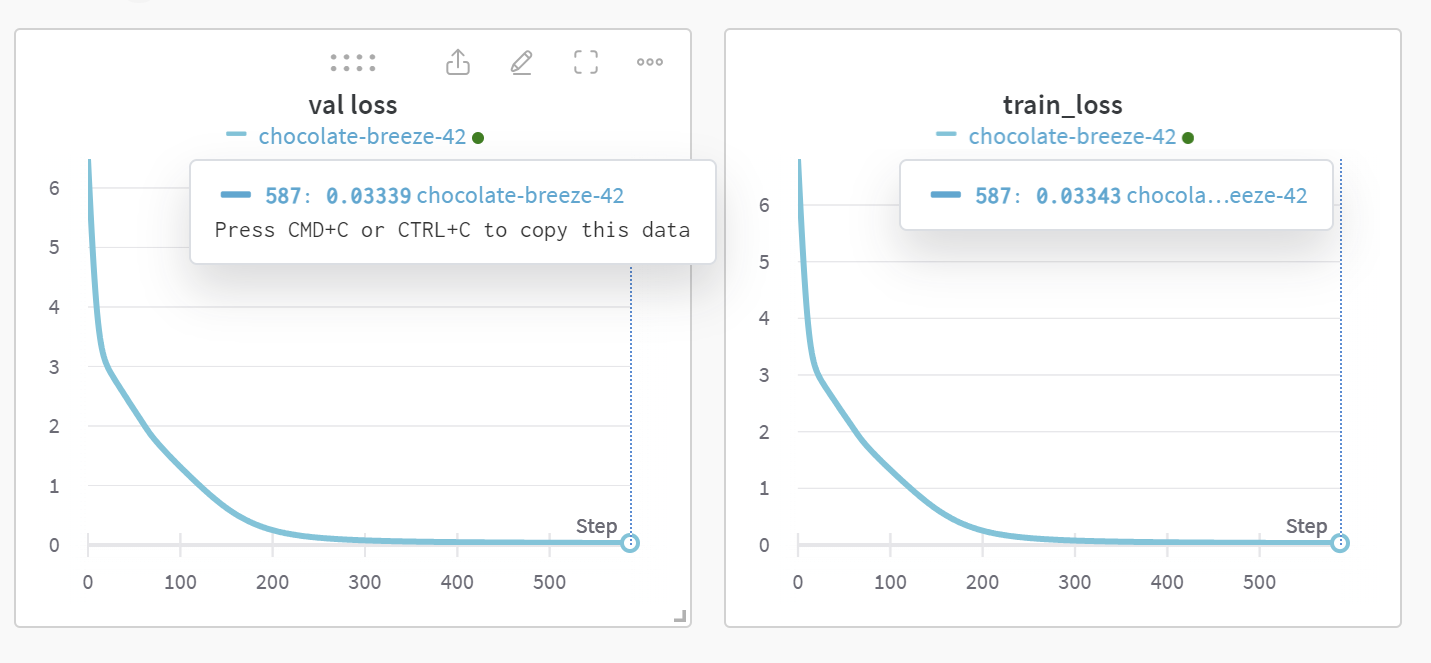

удалось переобучиться, значит работает